In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles

In [3]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [4]:
# function limit_func(param,pmin,pmax)
#     PL = pmax - pmin
#     offset = 0.5*(pmax + pmin)
#     PL/2 * (sin(pi * (param - offset)/PL) + 1) + pmin
# end
function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

limit_func (generic function with 1 method)

In [27]:
saved_ps = readdlm("C:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Archive\\2data_clean.txt");

In [132]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ] #I think the limit for Φ_ext is 0.96pi <-> 1.04pi
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p = [2, 14, 10, 0.5, 0.0, 1.51, 1, 0.995pi, 0.0]
p = saved_ps[1,:]
p[5] += pi/2

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = 0.7#limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ < t < Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = 2#limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [25]:
# Es, ψs = eigs(KinPot12 + p[4] .* Potential3, nev=2, which=:SR)
# ω_qubit = real(Es[2] - Es[1])
# overlap_scale = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

# ω_qubit, overlap_scale

In [133]:
function augmented_H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) .* Potential3
    V = chargecoupling
    hamil = H + pulse(p, t) .* V
    
    a = transpose(reshape(u[1:2*NHilbert],NHilbert,2))
    ψT = reshape(u[2*NHilbert+1:4*NHilbert],NHilbert,2)
    # a = reshape(u[1:NHilbert],1,:)
    # ψT = u[NHilbert+1:2*NHilbert]

    du[1:2*NHilbert] = reshape(transpose(im .* a * hamil),:)
    du[2*NHilbert+1:4*NHilbert] = reshape(-im .* hamil * ψT,:)
    # du[1:NHilbert] = im .* a * hamil
    # du[NHilbert+1:2*NHilbert] = -im .* hamil * ψT
    
    du[4*NHilbert+1:end] = 2*real(im * tr(a * V * ψT)) .* dpulsedp(p, t) + 2*real(im * tr(a * Potential3 * ψT)) .* dalphadp(p,t)
    # du[2*NHilbert+1:end] = 2*real(im * a * V * ψT) .* dpulsedp(p, t, ω_qubit, overlap_scale) + 2*real(im * a * Potential3 * ψT) .* dalphadp(p,t)
end

augmented_H_int! (generic function with 1 method)

In [ ]:
E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)

In [145]:
#buffer = [ω_qubit, overlap_scale, Potential3, ψ1s, ψT, counter]
# counter = 0
ps = []
ls = []

function H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) .* Potential3
    V = pulse(p, t) .* chargecoupling
    du[:] = - im * (H + V) * u
end

# ψ1s
function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        buffer[6] += 1
        if buffer[6] % 100 == 0
            writedlm("tmp_ps.txt",ps)
            writedlm("tmp_ls.txt",ls)
        end
        # buffer[3] = get_Pot3(0.995pi)#p[8])
        # Es, ψs = eigs(KinPot12 + p[4] .* buffer[3], nev=2, which=:SR)
        # buffer[1] = real(Es[2] - Es[1])
        # buffer[2] = abs(ψs[:,2]' * chargecoupling * ψs[:,1])

        
        # T = 30.0#p[3] + 2*p[2]
        forward_prob = ODEProblem(H_int!, ψ1s[:,1:2], (0.0, 30.0), p)
        sol = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)
        buffer[5] = sol.u[end]
    end
end

# function loss_func(buffer)
#     UT = abs2.(ψ1s'*buffer[5])
#     return 0.5 * (2 - UT[1,2] - UT[2,1])
# end

function loss_func(buffer)
    G = ψ1s'*buffer[5]
    return 1 - 0.25 * abs2(tr(sig_y'*G))
end

function f(p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    loss = loss_func(buffer)    
    push!(ps,copy(last_p))
    push!(ls,copy(loss))
    return loss
end

function g!(storage, p, last_p, buffer)
    calculate_common!(p, last_p, buffer)
    ψT = buffer[5]
    z_star = conj(tr(sig_y'*ψ1s'*ψT))
    a1 = dropdims(-z_star*0.25*sig_y[1,2] .* ψ1s[:,2]',dims=1)
    a2 = dropdims(-z_star*0.25*sig_y[2,1] .* ψ1s[:,1]',dims=1)

    # println("I need to change the final conditions in g! !")
    # a1 = - dropdims(ψT[:,1]'*ψ1s[:,2]*ψ1s[:,2]',dims=1)
    # a2 = - dropdims(ψT[:,2]'*ψ1s[:,1]*ψ1s[:,1]',dims=1)

    u0_aug = cat(a1,a2,ψT[:,1],ψT[:,2],zeros(ComplexF64,length(p)),dims=1)
    # u0_aug = cat(a1,ψT[:,1],zeros(ComplexF64,length(p)),dims=1)
    aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p)
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

    # push!(buffer,aug_sol)
    storage[:] = real(aug_sol.u[end][4*NHilbert+1:end])
    # storage[:] = real(aug_sol.u[end][2*NHilbert+1:end])
end

g! (generic function with 1 method)

In [146]:
initial_p = copy(p)
buffer = [nothing,nothing,nothing,nothing,zeros(ComplexF64,NHilbert,2),0]
last_p = similar(initial_p);

In [136]:
f(initial_p,last_p,buffer)

0.003095438230338421

In [68]:
G = ψ1s'*buffer[end-1]

2×2 Matrix{ComplexF64}:
 -2.63704e-5+1.46957e-5im     0.99851+0.0542763im
     0.33039-0.94383im     3.36373e-5-4.36377e-5im

In [69]:
angles = angle.(ψ1s'*buffer[end-1])
sig_phi = 0.5 * (angles[2,1] - angles[1,2])
sig_x = zeros(ComplexF64,2,2)
sig_x[1,2] = exp(-im*sig_phi)
sig_x[2,1] = exp(im*sig_phi)

1 - 0.25 * abs2(tr(G'*sig_x))

2.916035114131077e-5

In [70]:
sig_y = zeros(ComplexF64,2,2)
sig_y[1,2] = -im * exp(-im*sig_phi)
sig_y[2,1] = im * exp(im*sig_phi)

0.600550547326113 + 0.7995867933541086im

In [57]:
storage = similar(last_p)
g!(storage,p,last_p,buffer)

9-element Vector{Float64}:
 -0.0002082960916657895
 -0.001040251768587291
  0.0
  0.0063336179780699095
 -1.0514264562855308e-6
  0.00014907134298233318
  6.25298851559531e-7
  0.0
  2.358355889578332e-5

In [69]:
storage = similar(last_p)
g!(storage,p,last_p,buffer)

9-element Vector{Float64}:
  0.0
 -0.15570040375032715
  0.0
  0.0
 -0.0003897358519080403
 -0.015548679682594733
 -0.011912573229901581
  0.0
 -0.03324620367572547

In [147]:
res = optimize(p -> f(p, initial_p, buffer),
               (storage, p) -> g!(storage, p, last_p, buffer),
               initial_p,BFGS(),
               Optim.Options(f_tol=5e-5,g_tol=1e-8,show_every=10))

 * Status: success

 * Candidate solution
    Final objective value:     4.246303e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.95e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.95e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.82e-07 ≤ 5.0e-05
    |g(x)|                 = 2.67e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   765  (vs limit Inf)
    Iterations:    11
    f(x) calls:    34
    ∇f(x) calls:   34


In [152]:
# writedlm("tmp_ps.txt",ps)
# writedlm("tmp_ls.txt",ls)
# ps = readdlm("tmp_ps.txt")
# ls = readdlm("tmp_ls.txt");

In [81]:
p

9-element Vector{Float64}:
  2.0
 10.0
 10.0
  0.7
  0.5418
  2.4237061150395447
  3.44314831140435
  3.1258846903218442
  0.05289

In [149]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
  2.0
 10.0
 10.0
  0.7
  1.8410836437809366
  2.4788560906225645
  3.527526663435302
  3.1258846903218442
 -0.27721491876638443

In [14]:
mask = ones(length(p_new))
mask[5] = 0
mask[6] = 0

0

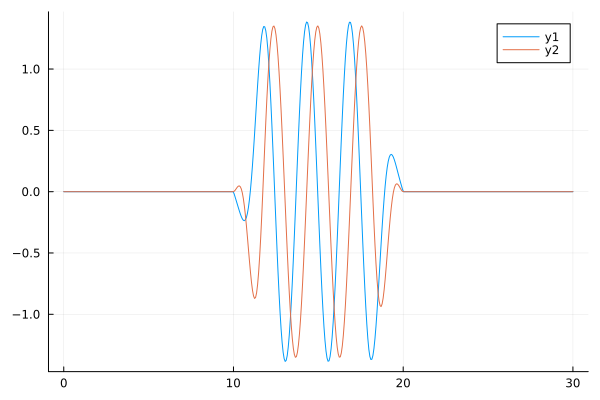

In [150]:
times = LinRange(0,30.0,500)

plot(times, [[pulse(p_new,t) for t in times],
             [pulse(saved_ps[1,:],t) for t in times]])

# plot(times,[[pulse(p_new,t) for t in times],
#             [pulse(p,t) for t in times],
#             [pulse(p_new .* mask,t) for t in times],
#             [pulse(p.*mask,t) for t in times],
#             [alpha(p,t) for t in times],
#             [alpha(p,t) for t in times]])

In [151]:
res

 * Status: success

 * Candidate solution
    Final objective value:     4.246303e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.95e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.95e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.05e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.82e-07 ≤ 5.0e-05
    |g(x)|                 = 2.67e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   765  (vs limit Inf)
    Iterations:    11
    f(x) calls:    34
    ∇f(x) calls:   34


In [90]:
forward_prob = ODEProblem(H_int!, ψ1s, (0.0, 30.0), p_new)
sol_new = solve(forward_prob, p=p_new, saveat=LinRange(0,30.0,1000), reltol=1e-12, abstol=1e-15);

In [40]:
# tmp'*ψ1s[:,2]
# sol_new.u[end,1,:]

1-element Vector{Matrix{ComplexF64}}:
 [7.006780045763737e-11 + 6.245978559780513e-10im -5.18428002798862e-10 + 3.7282315214838966e-10im; -2.3691345083466753e-9 + 3.4852295059587322e-9im -2.390575375334726e-9 + 3.923363473118686e-9im; … ; 2.142792931072744e-9 + 4.9464955624878515e-9im -5.558442856796538e-9 - 7.70572642298689e-11im; 1.2476435585913916e-11 + 7.845357448667374e-10im -7.234966881826244e-10 + 3.800265113635876e-10im]

In [41]:
tmp = sol_new.u[end][:,1]
2*real(-im * tmp'*ψ1s[:,2]*ψ1s[:,2]'* (Kinetic + Potential3) * tmp)

-0.14448257750286092

In [91]:
occs = zeros(Float64,1000,2,2)
# tmpPot3 = buffer[3]
for (i,t) in enumerate(sol_new.t)
    tmpEs, tmpψs = eigs(KinPot12 + alpha(p_new,t) .* Potential3, nev=2, which=:SR)
    occs[i,:,:] = abs2.(tmpψs'*sol_new.u[i])
end

In [92]:
zero = cat(occs[:,:,1],abs.(1 .- sum(occs,dims=2)[:,1,[1]]),dims=2)
one = cat(occs[:,:,2],abs.(1 .- sum(occs,dims=2)[:,1,[2]]),dims=2);

In [ ]:
# The optimized run:
# [Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# 2.906667984678622
# 12.109931540601726
# 10.0
# 0.5
# -18.04217394300753
# 6.786309632141689
# 1.83211636655623
# 3.1258846903218442
# -0.05818774908497257

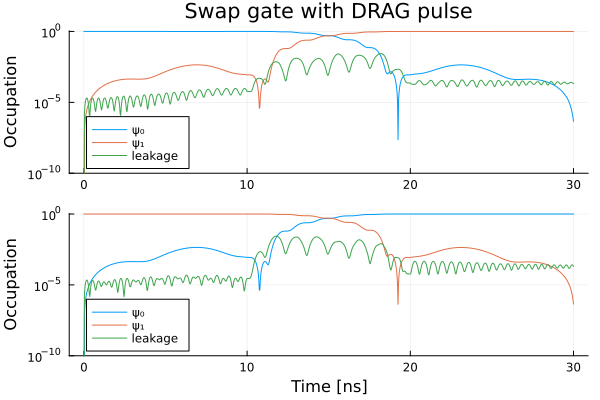

In [93]:
pzero = plot(sol_new.t,zero,title="Swap gate with DRAG pulse")
pone = plot(sol_new.t,one,xlabel="Time [ns]")

# plot(sol_new.t, [zero,one],yaxis=:log,ylims=(1e-10,1.1),layout=(2,1))
outputplot = plot(pzero,pone,
     layout=(2,1),
     yaxis=:log,
     ylims=(1e-10,1.1),
     legend=:bottomleft,
     label=["ψ₀" "ψ₁" "leakage"],
     ylabel="Occupation")

In [22]:
# 
UT = occs[end,:,:]
0.5 * (2 - UT[1,2] - UT[2,1])

0.0001870378407879958

In [23]:
# savefig(outputplot,"Figures/SwapOptPulseAndAlpha3_hightol.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\JuliaStuff\\Figures\\SwapOptPulseAndAlpha3_hightol.pdf"

In [100]:
probx = ODEProblem(H_int!, ψ1s, (0.0, 30.0), saved_ps[1,:])
sol_x = solve(probx, p=saved_ps[1,:], saveat=(30), reltol=1e-12, abstol=1e-15);

# proby = ODEProblem(H_int!, ψ1s, (0.0, 30.0), )
# sol_y = solve(probx, p=saved_ps[1,:], saveat=(30), reltol=1e-12, abstol=1e-15);

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 30.0
u: 2-element Vector{Matrix{ComplexF64}}:
 [3.835480849665381e-11 - 7.448568444452389e-10im 5.919670547471689e-10 + 4.0373478021226716e-10im; -2.1635208373600882e-9 - 4.867871946156856e-9im 2.37965927760719e-9 + 4.578863147311388e-9im; … ; 2.6520736127120763e-9 - 4.6199030652284644e-9im 5.13155723935998e-9 + 5.439552438757918e-10im; 3.835485923058807e-11 - 7.448569196194522e-10im 5.919670104341769e-10 + 4.03734872812221e-10im]
 [5.805725351806352e-10 - 4.4119019652571333e-10im 6.703539443154222e-11 - 7.23701007989814e-10im; 5.229368996482666e-9 - 8.805144843972614e-10im -2.1407986399112626e-9 - 4.8055508329662395e-9im; … ; 2.2731939155954466e-9 - 4.59508968687805e-9im 3.0335711279112604e-9 - 4.5602590437083805e-9im; 6.123894285865167e-10 - 4.1803161519965913e-10im 9.334610119569083e-11 - 7.32747301003395e-10im]

In [105]:
G_y = ψ1s'*sol_new.u[end]
G_x = ψ1s'*sol_x.u[end]

2×2 Matrix{ComplexF64}:
 -2.63689e-5+1.4693e-5im     0.99851+0.0542763im
     0.33039-0.94383im    3.36376e-5-4.36359e-5im

In [126]:
1 - 0.25 * abs2(tr(sig_x'*G_x)), 1 - 0.25 * abs2(tr(G_y'*sig_y))

(2.9040924383272326e-5, 0.0009032104155242138)

In [125]:
U_gc = zeros(ComplexF64,2,2)
U_gc[1,1] = exp(im*angles[1,2]/2)
U_gc[2,2] = exp(im*angles[2,1]/2)

U_gc'*G_x*U_gc

2×2 Matrix{ComplexF64}:
 -2.63689e-5+1.4693e-5im    0.830991-0.556257im
    0.830993-0.556259im   3.36376e-5-4.36359e-5im

In [123]:
U_gc'*G_y*U_gc

2×2 Matrix{ComplexF64}:
 0.00067837-1.28609e-5im      0.486266+0.873694im
  -0.531679-0.846822im    -0.000476177+0.000464042im